<a href="https://colab.research.google.com/github/LivingstonTardzenyuy/Deep-Learning-with-TensorFlow/blob/main/07_milestone_project_1_Food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone project 1: Food Vision Big.

# Check GPU

* Google colab offers free GPU, however, not all of them are compatiable with mixed precision training. The one that is compatiable is Tesla T4.

Hence we will uss a Tesla T4 in google Colab.

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ac342d65-5b74-95bc-7805-485f50d1c147)


### SetUp mixed precision

In [5]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision



policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


## Getting helper functions.

We will reUse all the helper functions we created in past module and use it here.
The script we've got available is found here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

In [7]:
# Download helper functions script.
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-12-30 02:00:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-30 02:00:02 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [8]:
# Import series of help functions for the notebook.
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Use TensorFlow Datasets to Download Data(TFDS)

In [9]:
# Get Tensorflow datassets.
import tensorflow_datasets as tfds

In [11]:
# List all available datasts in tf.
datasets_list = tfds.list_builders()   # list all available datasets
print("food101" in datasets_list)

True


In [17]:
# Load in the data (takes quite about 7 minutes)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True, # include labels
                                             with_info = True)

In [18]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [19]:
## Features of Food101 from TFDS

ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [22]:
# Get the class names.
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 data from TensorFlow Datasets.

To become one with the data, we want to find:
* Class names
* The shape of our input data
* The datatype of our input data
* What the labels look like (e.g are they one-hot encoded or label encoded)
* Do the labels match up with the class names ?.

In [25]:
# Take one sample of our train data.
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [29]:
# OUtput info about our training sample.

for image, label in train_one_sample:
  print(f"""
    The shape of our image tensor is: {image.shape}
    The datatype of our image tensor is: {image.dtype}
    The shape of our label tensor is: {label.shape}
    The datatype of our label tensor is: {label.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]
    }
  """)


    The shape of our image tensor is: (512, 512, 3)
    The datatype of our image tensor is: <dtype: 'uint8'>
    The shape of our label tensor is: ()
    The datatype of our label tensor is: <dtype: 'int64'>
    Target class from Food101 (tensor form): 8
    Class name (str form): bread_pudding
  


In [30]:
# What does our image tensor from TFDS's Food101 look like ?.
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[18,  6,  8],
        [18,  6,  8],
        [18,  6,  8],
        ...,
        [30, 15, 22],
        [29, 14, 21],
        [26, 11, 18]],

       [[22, 10, 12],
        [21,  9, 11],
        [20,  8, 10],
        ...,
        [35, 20, 27],
        [31, 16, 23],
        [26, 11, 18]],

       [[23, 13, 14],
        [21, 11, 12],
        [19,  9, 10],
        ...,
        [39, 26, 33],
        [36, 21, 28],
        [30, 15, 22]],

       ...,

       [[15,  4,  8],
        [15,  4,  8],
        [14,  5, 10],
        ...,
        [41,  9, 10],
        [39,  7,  8],
        [36,  4,  5]],

       [[16,  5,  9],
        [16,  5,  9],
        [16,  5, 11],
        ...,
        [42, 12, 12],
        [39,  9,  9],
        [35,  5,  5]],

       [[15,  4,  8],
        [15,  4,  8],
        [16,  5, 11],
        ...,
        [41, 11, 11],
        [39,  9,  9],
        [35,  5,  5]]], dtype=uint8)>

In [31]:
# What are the min and max of our images ?.
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from tensorflow dataset

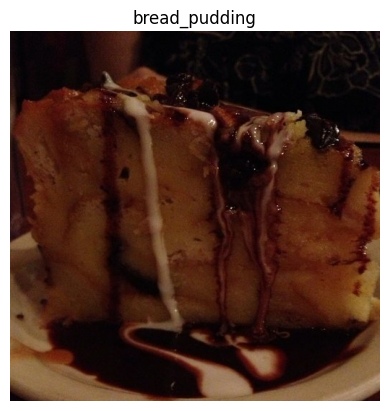

In [37]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])  # Add title to image to verify the label is associated with right image.
plt.axis(False);

## Create preprocessing functions for our data

Neural network perform well when our images are in a certain way (e.g batched, normalized, etc). Hence we have to look into this......

What we know about our data.

* In 'uinit8' datatype
* Comprised of all different size of tensors (different sized images)
* Not scaled(The pixel values are b/t 0 and 255

What we know models like:
* Data in 'float32' dtype (or for mixed precision 'float16' and 'float32')
* For batches, TensorFlow likes all of the tensors within a batch to be in the same
* Scaled (values between 0 & 1) also called normalized tensors generally perform better.

With this point in mind... we have to do some things to tackle preprocessing function.

Since we're going to be using an EfficientNetBx pretrained model from tf.keras.applications we don't need to rescale our data (These architectures have rescaling build-in).

Hence our function will.
1. Reshape our images to all the smae size.
2. Convert the dtype of our image tnesor from unit8 to float32

In [70]:
# Make a function for preprocessing images
def preprocess_image(image, label, image_size = 224):
  """
    Convert image datatype from 'uint8' -> 'float32'
    Resize image to 'image_size' x 'image_size'
  """

  image = tf.image.resize(image, [image_size, image_size])
  # image = image/225.  # Normalizing or scaling image values. But this is not required in EfficientNetBX since it is already build in...
  return tf.cast(image, tf.float32), label

In [71]:
# Preprocess a single image and check the output
preprocess_image(image, label)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[20.158163 ,  8.158163 , 10.158163 ],
         [18.42347  ,  7.6173472,  9.020408 ],
         [15.010203 ,  6.423469 ,  9.285714 ],
         ...,
         [26.285824 , 15.714351 , 23.07156  ],
         [31.091867 , 17.285728 , 24.285728 ],
         [28.754953 , 13.754952 , 20.754953 ]],
 
        [[18.92857  ,  8.928571 ,  9.928571 ],
         [16.214285 ,  7.0765305,  8.07653  ],
         [14.739796 ,  8.571429 , 10.627552 ],
         ...,
         [26.444029 , 15.872557 , 21.658293 ],
         [39.86226  , 26.862259 , 33.86226  ],
         [39.49479  , 24.494787 , 31.494787 ]],
 
        [[17.066326 ,  8.709184 ,  9.494898 ],
         [16.255102 , 10.086736 , 10.142858 ],
         [15.142857 ,  9.908163 , 11.52551  ],
         ...,
         [26.688967 , 16.117495 , 21.474659 ],
         [34.18364  , 22.183641 , 26.183641 ],
         [39.199165 , 24.199165 , 28.770594 ]],
 
        ...,
 
        [[13.862259 ,  4.862259 

## Batch and prepare datasets

We're now going to make our data input pipeline run really fast. For more info get to this: https://www.tensorflow.org/guide/data_performance

In [72]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func = preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shufle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Turn test data into batches (don't need to shuffle)
test_data = test_data.map(preprocess_image).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data, test_data

ValueError: in user code:

    File "<ipython-input-46-9bebeb922069>", line 7, in preprocess_image  *
        image = tf.image.resize(image, [image_size, image_size])

    ValueError: 'images' must have either 3 or 4 dimensions.


In [74]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>